### Additional Physical Activity Metrics - ENMO (Euclidean norm minus one )

Accelerometer / scaling / ENMO

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/leasaab/Documents/Dev/AX3-Project/data/FemmeCardio.csv"

data = pd.read_csv(file_path)

timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # All remaining columns are sensor data

# Convert the timestamp column to datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column], errors='coerce')  # Handle invalid dates

# Calculate the sampling interval (in seconds)
sampling_interval = (
    pd.to_datetime(data[timestamp_column].iloc[1]) -  # Access a single row
    pd.to_datetime(data[timestamp_column].iloc[0])
).total_seconds()

# Create a relative time axis (in minutes)
data['relative_time_minutes'] = data.index * sampling_interval

# Define axis labels for clarity
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
colors = {'X': 'blue', 'Y': 'red', 'Z': 'green'}  # Define colors for each signal

### Correction du décalage pour recentrer les moyennes autour de 1g pour l’axe vertical (Z), et 0g pour les autres axes. Puis appliquer un filtre passe-bas:

In [21]:
calibration_offset = {
    '-0.296875': -1.62,   # Offset pour l'axe X
    '0.703125': -0.88,    # Offset pour l'axe Y
    '-0.343750': -1.16    # Offset pour l'axe Z
}
for col, offset in calibration_offset.items():
    data[col] = data[col] - offset

from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

fs = 1 / sampling_interval  # Fréquence d'échantillonnage en Hz
cutoff = 2  # Fréquence de coupure en Hz
for col in signal_columns:
    data[col] = lowpass_filter(data[col], cutoff, fs)

   relative_time_minutes  ENMO
0                  0.000   0.0
1                  0.002   0.0
2                  0.004   0.0
3                  0.006   0.0
4                  0.008   0.0


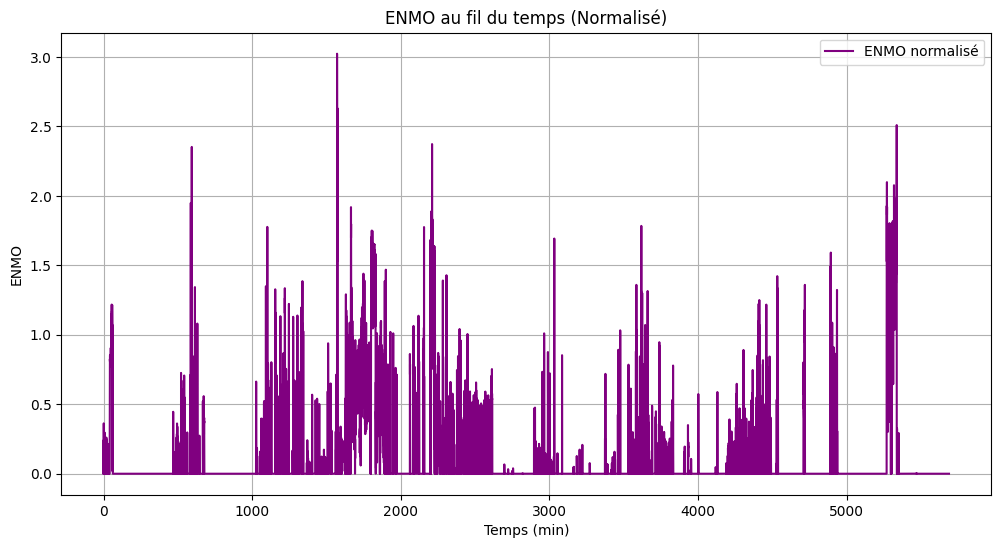

In [23]:
import numpy as np

# Calcul de la norme euclidienne des accélérations (X, Y, Z)
data.loc[:, 'norm'] = np.sqrt(data['-0.296875']**2 + data['0.703125']**2 + data['-0.343750']**2)

# Normalisation : centrer et réduire les données
mean_norm = data['norm'].mean()
std_norm = data['norm'].std()
data.loc[:, 'norm_normalized'] = (data['norm'] - mean_norm) / std_norm

# Calcul de l'ENMO : norme normalisée - 1, et on garde la valeur maximale entre 0 et la norme
data.loc[:, 'ENMO'] = np.maximum(data['norm_normalized'] - 1, 0)

# Affichage des premiers résultats
print(data[['relative_time_minutes', 'ENMO']].head())

# Visualisation de l'ENMO normalisé
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_minutes'], data['ENMO'], label="ENMO normalisé", color='purple')
plt.title("ENMO au fil du temps (Normalisé)")
plt.xlabel("Temps (min)")
plt.ylabel("ENMO")
plt.legend()
plt.grid(True)
plt.show()

1. Analyse des plages d’intensité

Activités faibles ou inactives (trajet) :
- Généralement avec un ENMO très bas (< 0.1).
Ces moments peuvent être exclus de l’analyse principale pour mieux différencier les efforts modérés et intenses.

Activités modérées (marche rapide) :
- ENMO typique : entre 0.5 et 1.5.
Cela couvre la plage de marche rapide.

Activités intenses (sprint) :
- ENMO typique : entre 1.5 et 3.0.

2. Seuils choisis:

Pour distinguer clairement les trois types d’effort:
	1.	ENMO ≤ 0.5 : Activités faibles ou inactives (à exclure de l’analyse principale).
	2.	0.5 < ENMO ≤ 1.5 : Activités modérées (marche rapide).
	3.	ENMO > 1.5 : Activités intenses (sprint).



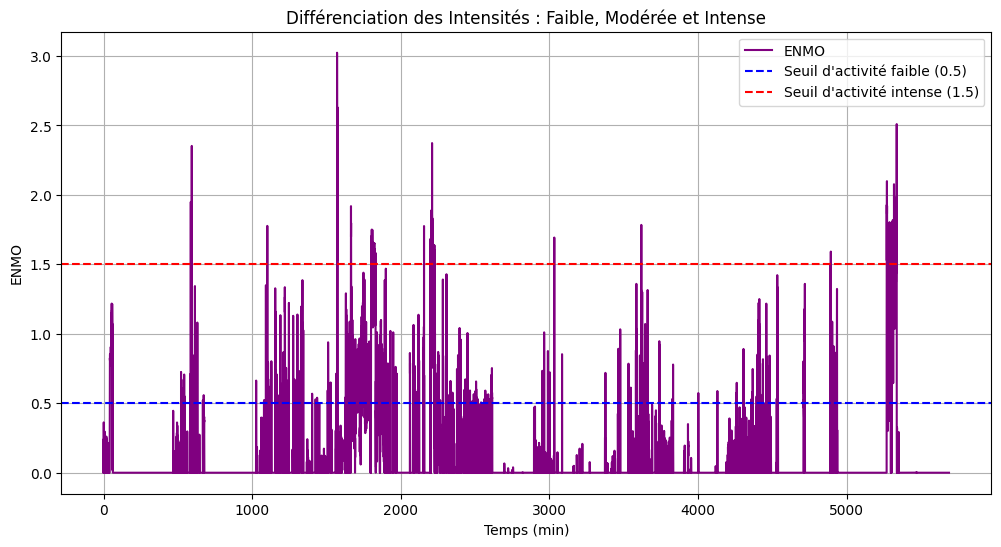

In [24]:
# Définir les seuils pour les intensités
seuil_faible = 0.5
seuil_intense = 1.5

# Classifier les moments d'intensité
moments_faibles = data[data['ENMO'] <= seuil_faible]
moments_moderes = data[(data['ENMO'] > seuil_faible) & (data['ENMO'] <= seuil_intense)]
moments_intenses = data[data['ENMO'] > seuil_intense]

# Visualisation des intensités
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_minutes'], data['ENMO'], label="ENMO", color='purple')
plt.axhline(y=seuil_faible, color='blue', linestyle='--', label="Seuil d'activité faible (0.5)")
plt.axhline(y=seuil_intense, color='red', linestyle='--', label="Seuil d'activité intense (1.5)")
plt.title("Différenciation des Intensités : Faible, Modérée et Intense")
plt.xlabel("Temps (min)")
plt.ylabel("ENMO")
plt.legend()
plt.grid(True)
plt.show()

Calcul des statistiques descriptives comme la moyenne, la médiane ou les écarts-types pour mieux comprendre la distribution de l'ENMO

In [25]:
# Statistiques de base
stats = data['ENMO'].describe()
print(stats)

count    2.844599e+06
mean     9.728115e-02
std      2.804413e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.023497e+00
Name: ENMO, dtype: float64


# Méthode ENMO basée sur les époques:

On regroupe les données en intervalles de temps fixes (par exemple, 1 seconde ou 5 secondes). Pour chaque intervalle (ou époque), on calcule la moyenne des données.

1.	Échantillonnage très fin :

Une époque de 0.1 seconde a été choisie dans le but de regrouper les données en intervalles très courts, ce qui reflète des variations très rapides. Cela permet de capturer des détails très fins dans les mouvements ou les variations d’accélération. Une grande précision temporelle est utile pour des activités comme le sprint.

Statistiques des époques :
count    114.000000
mean       0.097097
std        0.195943
min        0.000000
25%        0.000000
50%        0.024388
75%        0.089445
max        1.105334
Name: ENMO, dtype: float64


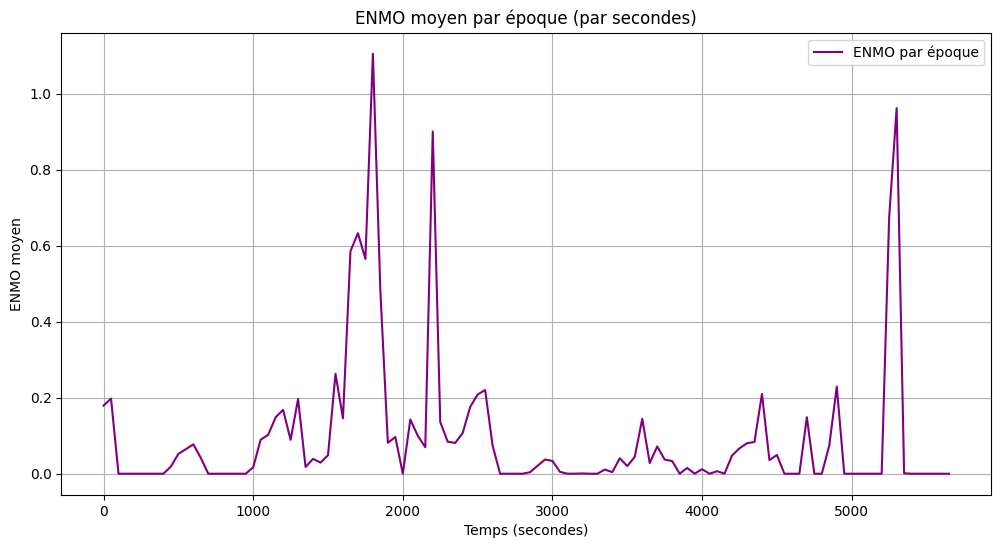

In [34]:
# Regrouper par époques (par exemple, 1 seconde)
epoch_duration = 0.1 / sampling_interval  # Durée d'une époque en secondes
data['epoch_index'] = (data['relative_time_minutes'] // epoch_duration).astype(int)  # Index des époques

# Calculer la moyenne de l'ENMO pour chaque époque
epoch_means = data.groupby('epoch_index')['ENMO'].mean()

# Afficher les résultats
print("Statistiques des époques :")
print(epoch_means.describe())

# Visualiser l'ENMO par époques
plt.figure(figsize=(12, 6))
plt.plot(epoch_means.index * epoch_duration, epoch_means, label="ENMO par époque", color='purple')
plt.title("ENMO moyen par époque (par secondes)")
plt.xlabel("Temps (secondes)")
plt.ylabel("ENMO moyen")
plt.grid(True)
plt.legend()
plt.show()

In [36]:
# Fonction d'estimation du rythme cardiaque en fonction de l'ENMO
def estimate_heart_rate(enmo):
    """
    Estime le rythme cardiaque en fonction de l'ENMO.
    """
    if enmo <= 0.5:
        return 100 + enmo * 40  # Rythme cardiaque pour marche rapide (~100-120 BPM)
    elif enmo <= 1.0:
        return 120 + (enmo - 0.5) * 80  # Transition marche rapide-sprint (~120-160 BPM)
    else:
        return 140 + (enmo - 1.0) * 100  # Sprint intense (~140-180 BPM)

# Appliquer la fonction d'estimation
data['EstimatedHeartRate'] = data['ENMO'].apply(estimate_heart_rate)

# Calculer les statistiques essentielles
min_hr = data['EstimatedHeartRate'].min()
max_hr = data['EstimatedHeartRate'].max()
mean_hr = data['EstimatedHeartRate'].mean()

# Afficher les résultats numériques
print(f"Rythme cardiaque minimum estimé : {min_hr:.2f} BPM")
print(f"Rythme cardiaque maximum estimé : {max_hr:.2f} BPM")
print(f"Rythme cardiaque moyen estimé : {mean_hr:.2f} BPM")

Rythme cardiaque minimum estimé : 100.00 BPM
Rythme cardiaque maximum estimé : 342.35 BPM
Rythme cardiaque moyen estimé : 104.94 BPM


# Statistiques

In [40]:
import numpy as np

# Calculer les statistiques de l'ENMO
enmo_mean = data['ENMO'].mean()
enmo_std = data['ENMO'].std()
enmo_max = data['ENMO'].max()
enmo_min = data['ENMO'].min()

# Calculer les caractéristiques de l'intégration ENMO (par époques, si défini)
epoch_mean = epoch_means.mean() if 'epoch_means' in locals() else None
epoch_std = epoch_means.std() if 'epoch_means' in locals() else None

# Résumé des statistiques
statistics = {
    'ENMO_mean': enmo_mean,
    'ENMO_std': enmo_std,
    'ENMO_max': enmo_max,
    'ENMO_min': enmo_min,
    'Epoch_mean': epoch_mean,
    'Epoch_std': epoch_std
}

# Afficher les valeurs numériques
for key, value in statistics.items():
    if value is not None:
        print(f"{key}: {value:.4f}")

ENMO_mean: 0.0973
ENMO_std: 0.2804
ENMO_max: 3.0235
ENMO_min: 0.0000
Epoch_mean: 0.0971
Epoch_std: 0.1959


Une valeur moyenne faible (0.0973) suggère que la majorité du temps est passée dans des activités légères ou des périodes de faible mouvement. Cela correspond bien à une activité où les périodes actives (marche rapide et sprint) sont entrecoupées de moments d’inactivité ou de faible intensité.

ENMO_std: 0.2804: Une variabilité modérée indique qu’il existe des fluctuations dans l’intensité, ce qui reflète probablement l’alternance entre phases actives (marche/sprint) et phases calmes.

Un maximum à 3.0235 est cohérent avec des activités intenses comme le sprint. Cela montre que le capteur a bien capturé les moments de haute intensité.

Une valeur minimale de 0.0 est attendue, correspondant à des périodes d’inactivité totale.

2. Interprétation des statistiques par époques :

La moyenne par époque est très proche de la moyenne globale (0.0973), ce qui montre que les regroupements par époque ne modifient pas la tendance globale de faible intensité.

Epoch_std: 0.1959: Une variabilité réduite par rapport à l’écart type global (0.2804) indique que la répartition de l’intensité est plus lissée lorsque les données sont regroupées par époques. Cela peut être dû à l’intégration des valeurs sur des périodes définies, réduisant l’impact des pics extrêmes.

# Analyse biomédicale :
- Plus l’ENMO moyen est élevé, plus l’effort physique total est important.
- La proportion d’effort intense : En comparant les valeurs au seuil de 1.0 (activité intense).

In [42]:
# Filtrer les données entre la 1000e et la 3000e seconde
filtered_data = data[(data['relative_time_minutes'] >= 1000) & (data['relative_time_minutes'] <= 3000)]

# Définir le seuil pour l'activité intense
intense_threshold = 1.0

# Nombre total de données filtrées
total_samples_filtered = len(filtered_data)

# Nombre de données au-dessus du seuil dans les données filtrées
intense_samples_filtered = filtered_data[filtered_data['ENMO'] > intense_threshold].shape[0]

# Proportion d'effort intense dans l'intervalle
proportion_intense_filtered = (intense_samples_filtered / total_samples_filtered) * 100

# Résultat
print(f"Proportion d'effort intense (1000-3000 secondes) : {proportion_intense_filtered:.2f}%")

Proportion d'effort intense (1000-3000 secondes) : 4.18%
